In [32]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
df = pd.read_csv('feature_selection_top_states.csv', parse_dates = True)
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,contact_tracing,debt_relief,restrictions_on_internal_movement,current_intensive_care_patients,facial_coverings,public_information_campaigns,testing_policy,income_support,public_transport_closing,new_cases_50_min,...,booster_rate,vaccination_policy,maximum_temperature_celsius,prop_age85plus,prop_age6064,prop_age8084,vaccination_rate_1dose,PEOPLE_POSITIVE_NEW_CASES_COUNT,PROVINCE_STATE_NAME,Date
0,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California,2020-03-01
1,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California,2020-03-02
2,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,7,California,2020-03-03
3,1.0,1.0,0.0,112.5,0.0,1.0,1.0,0.0,0.0,5.0,...,0.0,0.0,24.685185,1.860398,5.818187,1.71647,0.0,10,California,2020-03-04
4,1.0,1.0,0.0,112.5,0.0,1.0,1.0,1.0,0.0,5.0,...,0.0,0.0,25.753086,1.860398,5.818187,1.71647,0.0,12,California,2020-03-05


In [3]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']
ca_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
ca_df.head(3)

,contact_tracing,debt_relief,restrictions_on_internal_movement,current_intensive_care_patients,facial_coverings,public_information_campaigns,testing_policy,income_support,public_transport_closing,new_cases_50_min,...,NATIVE_PEOPLES,booster_rate,vaccination_policy,maximum_temperature_celsius,prop_age85plus,prop_age6064,prop_age8084,vaccination_rate_1dose,PEOPLE_POSITIVE_NEW_CASES_COUNT,Date
0,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,2020-03-01
1,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,2020-03-02
2,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,7,2020-03-03


In [4]:
#separate train & test sets
train_size = int(len(ca_df)* 0.85)
ca_train, ca_test = ca_df[0:train_size], ca_df[train_size:]

In [5]:
#identify best features among 179 using PCA -- to help speed up 
X_ca_train = ca_train.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
X_ca_test = ca_test.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
y_ca_train = ca_train['PEOPLE_POSITIVE_NEW_CASES_COUNT']
y_ca_test = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT']

# Keep the 'Date' column separate and not to be scaled or PCA-transformed
Date_train = X_ca_train[['Date']].reset_index(drop=True)
Date_test = X_ca_test[['Date']].reset_index(drop=True)

# Exclude the 'Date' column from scaling and PCA
X_train_ca_numerical = X_ca_train.drop(columns=['Date'])
X_test_ca_numerical = X_ca_test.drop(columns=['Date'])


#standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ca_numerical)
X_test_scaled = scaler.fit_transform(X_test_ca_numerical)

#PCA to reduce the features to the top 40 principal components 
pca = PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

#transformed data `X_pca` has only the top 40 principal components now
X_train_pca_df = pd.DataFrame(data = X_train_pca)
X_test_pca_df = pd.DataFrame(data = X_test_pca)

# Concatenate the PCA components with the 'Date' column
X_train_final = pd.concat([Date_train, X_train_pca_df], axis=1)
X_test_final = pd.concat([Date_test, X_test_pca_df], axis=1)

In [6]:
#forward selection algorithm to determine optimal feature combination for multivariate prophet model
target_column = 'PEOPLE_POSITIVE_NEW_CASES_COUNT'

#forward selection function to include target data as separate arguments
def forward_selection(train_df, test_df, y_train, y_test, target_column):
    train_df.columns = train_df.columns.astype(str)
    test_df.columns = test_df.columns.astype(str)

    features = [col for col in train_df.columns if col != 'Date']
    included_features = []
    best_mae = np.inf
    improvement = True
    
    while improvement and features:
        improvement = False
        for feature in features:
            test_features = included_features + [feature]
            
            # Initialize and setup Prophet model
            model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
            for f in test_features:
                model.add_regressor(f, standardize=False)
                
            # Prepare training data
            train_data = train_df[['Date'] + test_features]
            train_data['y'] = y_train
            train_data = train_data.rename(columns={'Date': 'ds'})
            
            model.fit(train_data)
            
            # Prepare testing data
            test_data = test_df[['Date'] + test_features]
            test_data['y'] = y_test  # This line is not used for prediction but kept for consistency
            test_data = test_data.rename(columns={'Date': 'ds'})
            
            forecast = model.predict(test_data.drop(columns=['y']))
            
            # Evaluate the model
            mae = mean_absolute_error(y_test, forecast['yhat'])
            
            if mae < best_mae:
                best_feature = feature
                best_mae = mae
                improvement = True
                
        if improvement:
            included_features.append(best_feature)
            features.remove(best_feature)
            print(f"Added {best_feature} to the model, new best MAE: {best_mae}")
    
    print(f"Final features selected: {included_features}")
    return included_features

In [13]:
# Run the updated forward selection
selected_features = forward_selection(X_train_final, X_test_final, y_ca_train, y_ca_test, target_column)

02:51:18 - cmdstanpy - INFO - Chain [1] start processing
02:51:18 - cmdstanpy - INFO - Chain [1] done processing
02:51:18 - cmdstanpy - INFO - Chain [1] start processing
02:51:18 - cmdstanpy - INFO - Chain [1] done processing
02:51:19 - cmdstanpy - INFO - Chain [1] start processing
02:51:19 - cmdstanpy - INFO - Chain [1] done processing
02:51:19 - cmdstanpy - INFO - Chain [1] start processing
02:51:19 - cmdstanpy - INFO - Chain [1] done processing
02:51:19 - cmdstanpy - INFO - Chain [1] start processing
02:51:19 - cmdstanpy - INFO - Chain [1] done processing
02:51:19 - cmdstanpy - INFO - Chain [1] start processing
02:51:20 - cmdstanpy - INFO - Chain [1] done processing
02:51:20 - cmdstanpy - INFO - Chain [1] start processing
02:51:20 - cmdstanpy - INFO - Chain [1] done processing
02:51:20 - cmdstanpy - INFO - Chain [1] start processing
02:51:20 - cmdstanpy - INFO - Chain [1] done processing
02:51:20 - cmdstanpy - INFO - Chain [1] start processing
02:51:20 - cmdstanpy - INFO - Chain [1]

Added 2 to the model, new best MAE: 25519.824761030122


02:51:30 - cmdstanpy - INFO - Chain [1] done processing
02:51:30 - cmdstanpy - INFO - Chain [1] start processing
02:51:30 - cmdstanpy - INFO - Chain [1] done processing
02:51:30 - cmdstanpy - INFO - Chain [1] start processing
02:51:30 - cmdstanpy - INFO - Chain [1] done processing
02:51:30 - cmdstanpy - INFO - Chain [1] start processing
02:51:31 - cmdstanpy - INFO - Chain [1] done processing
02:51:31 - cmdstanpy - INFO - Chain [1] start processing
02:51:31 - cmdstanpy - INFO - Chain [1] done processing
02:51:31 - cmdstanpy - INFO - Chain [1] start processing
02:51:31 - cmdstanpy - INFO - Chain [1] done processing
02:51:31 - cmdstanpy - INFO - Chain [1] start processing
02:51:31 - cmdstanpy - INFO - Chain [1] done processing
02:51:32 - cmdstanpy - INFO - Chain [1] start processing
02:51:32 - cmdstanpy - INFO - Chain [1] done processing
02:51:32 - cmdstanpy - INFO - Chain [1] start processing
02:51:32 - cmdstanpy - INFO - Chain [1] done processing
02:51:32 - cmdstanpy - INFO - Chain [1] 

Added 11 to the model, new best MAE: 24075.369196976062


02:51:42 - cmdstanpy - INFO - Chain [1] done processing
02:51:42 - cmdstanpy - INFO - Chain [1] start processing
02:51:42 - cmdstanpy - INFO - Chain [1] done processing
02:51:42 - cmdstanpy - INFO - Chain [1] start processing
02:51:42 - cmdstanpy - INFO - Chain [1] done processing
02:51:42 - cmdstanpy - INFO - Chain [1] start processing
02:51:43 - cmdstanpy - INFO - Chain [1] done processing
02:51:43 - cmdstanpy - INFO - Chain [1] start processing
02:51:43 - cmdstanpy - INFO - Chain [1] done processing
02:51:43 - cmdstanpy - INFO - Chain [1] start processing
02:51:43 - cmdstanpy - INFO - Chain [1] done processing
02:51:43 - cmdstanpy - INFO - Chain [1] start processing
02:51:44 - cmdstanpy - INFO - Chain [1] done processing
02:51:44 - cmdstanpy - INFO - Chain [1] start processing
02:51:44 - cmdstanpy - INFO - Chain [1] done processing
02:51:44 - cmdstanpy - INFO - Chain [1] start processing
02:51:44 - cmdstanpy - INFO - Chain [1] done processing
02:51:44 - cmdstanpy - INFO - Chain [1] 

Added 8 to the model, new best MAE: 23672.43731453344


02:51:54 - cmdstanpy - INFO - Chain [1] done processing
02:51:54 - cmdstanpy - INFO - Chain [1] start processing
02:51:54 - cmdstanpy - INFO - Chain [1] done processing
02:51:55 - cmdstanpy - INFO - Chain [1] start processing
02:51:55 - cmdstanpy - INFO - Chain [1] done processing
02:51:55 - cmdstanpy - INFO - Chain [1] start processing
02:51:55 - cmdstanpy - INFO - Chain [1] done processing
02:51:55 - cmdstanpy - INFO - Chain [1] start processing
02:51:55 - cmdstanpy - INFO - Chain [1] done processing
02:51:56 - cmdstanpy - INFO - Chain [1] start processing
02:51:56 - cmdstanpy - INFO - Chain [1] done processing
02:51:56 - cmdstanpy - INFO - Chain [1] start processing
02:51:56 - cmdstanpy - INFO - Chain [1] done processing
02:51:56 - cmdstanpy - INFO - Chain [1] start processing
02:51:56 - cmdstanpy - INFO - Chain [1] done processing
02:51:57 - cmdstanpy - INFO - Chain [1] start processing
02:51:57 - cmdstanpy - INFO - Chain [1] done processing
02:51:57 - cmdstanpy - INFO - Chain [1] 

Added 4 to the model, new best MAE: 23140.072405412033


02:52:07 - cmdstanpy - INFO - Chain [1] done processing
02:52:07 - cmdstanpy - INFO - Chain [1] start processing
02:52:07 - cmdstanpy - INFO - Chain [1] done processing
02:52:08 - cmdstanpy - INFO - Chain [1] start processing
02:52:08 - cmdstanpy - INFO - Chain [1] done processing
02:52:08 - cmdstanpy - INFO - Chain [1] start processing
02:52:08 - cmdstanpy - INFO - Chain [1] done processing
02:52:08 - cmdstanpy - INFO - Chain [1] start processing
02:52:08 - cmdstanpy - INFO - Chain [1] done processing
02:52:09 - cmdstanpy - INFO - Chain [1] start processing
02:52:09 - cmdstanpy - INFO - Chain [1] done processing
02:52:09 - cmdstanpy - INFO - Chain [1] start processing
02:52:09 - cmdstanpy - INFO - Chain [1] done processing
02:52:09 - cmdstanpy - INFO - Chain [1] start processing
02:52:09 - cmdstanpy - INFO - Chain [1] done processing
02:52:10 - cmdstanpy - INFO - Chain [1] start processing
02:52:10 - cmdstanpy - INFO - Chain [1] done processing
02:52:10 - cmdstanpy - INFO - Chain [1] 

Added 9 to the model, new best MAE: 22867.571345403107


02:52:20 - cmdstanpy - INFO - Chain [1] done processing
02:52:20 - cmdstanpy - INFO - Chain [1] start processing
02:52:20 - cmdstanpy - INFO - Chain [1] done processing
02:52:21 - cmdstanpy - INFO - Chain [1] start processing
02:52:21 - cmdstanpy - INFO - Chain [1] done processing
02:52:21 - cmdstanpy - INFO - Chain [1] start processing
02:52:21 - cmdstanpy - INFO - Chain [1] done processing
02:52:21 - cmdstanpy - INFO - Chain [1] start processing
02:52:22 - cmdstanpy - INFO - Chain [1] done processing
02:52:22 - cmdstanpy - INFO - Chain [1] start processing
02:52:22 - cmdstanpy - INFO - Chain [1] done processing
02:52:22 - cmdstanpy - INFO - Chain [1] start processing
02:52:22 - cmdstanpy - INFO - Chain [1] done processing
02:52:22 - cmdstanpy - INFO - Chain [1] start processing
02:52:23 - cmdstanpy - INFO - Chain [1] done processing
02:52:23 - cmdstanpy - INFO - Chain [1] start processing
02:52:23 - cmdstanpy - INFO - Chain [1] done processing
02:52:24 - cmdstanpy - INFO - Chain [1] 

Added 7 to the model, new best MAE: 21977.80919294014


02:52:33 - cmdstanpy - INFO - Chain [1] done processing
02:52:33 - cmdstanpy - INFO - Chain [1] start processing
02:52:34 - cmdstanpy - INFO - Chain [1] done processing
02:52:34 - cmdstanpy - INFO - Chain [1] start processing
02:52:34 - cmdstanpy - INFO - Chain [1] done processing
02:52:34 - cmdstanpy - INFO - Chain [1] start processing
02:52:34 - cmdstanpy - INFO - Chain [1] done processing
02:52:35 - cmdstanpy - INFO - Chain [1] start processing
02:52:35 - cmdstanpy - INFO - Chain [1] done processing
02:52:35 - cmdstanpy - INFO - Chain [1] start processing
02:52:35 - cmdstanpy - INFO - Chain [1] done processing
02:52:35 - cmdstanpy - INFO - Chain [1] start processing
02:52:36 - cmdstanpy - INFO - Chain [1] done processing
02:52:36 - cmdstanpy - INFO - Chain [1] start processing
02:52:36 - cmdstanpy - INFO - Chain [1] done processing
02:52:36 - cmdstanpy - INFO - Chain [1] start processing
02:52:36 - cmdstanpy - INFO - Chain [1] done processing
02:52:37 - cmdstanpy - INFO - Chain [1] 

Added 31 to the model, new best MAE: 21633.500559198754


02:52:46 - cmdstanpy - INFO - Chain [1] done processing
02:52:47 - cmdstanpy - INFO - Chain [1] start processing
02:52:47 - cmdstanpy - INFO - Chain [1] done processing
02:52:47 - cmdstanpy - INFO - Chain [1] start processing
02:52:47 - cmdstanpy - INFO - Chain [1] done processing
02:52:47 - cmdstanpy - INFO - Chain [1] start processing
02:52:48 - cmdstanpy - INFO - Chain [1] done processing
02:52:48 - cmdstanpy - INFO - Chain [1] start processing
02:52:48 - cmdstanpy - INFO - Chain [1] done processing
02:52:48 - cmdstanpy - INFO - Chain [1] start processing
02:52:48 - cmdstanpy - INFO - Chain [1] done processing
02:52:49 - cmdstanpy - INFO - Chain [1] start processing
02:52:49 - cmdstanpy - INFO - Chain [1] done processing
02:52:49 - cmdstanpy - INFO - Chain [1] start processing
02:52:49 - cmdstanpy - INFO - Chain [1] done processing
02:52:49 - cmdstanpy - INFO - Chain [1] start processing
02:52:50 - cmdstanpy - INFO - Chain [1] done processing
02:52:50 - cmdstanpy - INFO - Chain [1] 

Added 3 to the model, new best MAE: 21629.994944722195


02:53:00 - cmdstanpy - INFO - Chain [1] done processing
02:53:00 - cmdstanpy - INFO - Chain [1] start processing
02:53:00 - cmdstanpy - INFO - Chain [1] done processing
02:53:01 - cmdstanpy - INFO - Chain [1] start processing
02:53:01 - cmdstanpy - INFO - Chain [1] done processing
02:53:01 - cmdstanpy - INFO - Chain [1] start processing
02:53:01 - cmdstanpy - INFO - Chain [1] done processing
02:53:02 - cmdstanpy - INFO - Chain [1] start processing
02:53:02 - cmdstanpy - INFO - Chain [1] done processing
02:53:02 - cmdstanpy - INFO - Chain [1] start processing
02:53:02 - cmdstanpy - INFO - Chain [1] done processing
02:53:02 - cmdstanpy - INFO - Chain [1] start processing
02:53:03 - cmdstanpy - INFO - Chain [1] done processing
02:53:03 - cmdstanpy - INFO - Chain [1] start processing
02:53:03 - cmdstanpy - INFO - Chain [1] done processing
02:53:03 - cmdstanpy - INFO - Chain [1] start processing
02:53:03 - cmdstanpy - INFO - Chain [1] done processing
02:53:04 - cmdstanpy - INFO - Chain [1] 

Added 22 to the model, new best MAE: 20583.449829477875


02:53:14 - cmdstanpy - INFO - Chain [1] done processing
02:53:15 - cmdstanpy - INFO - Chain [1] start processing
02:53:15 - cmdstanpy - INFO - Chain [1] done processing
02:53:15 - cmdstanpy - INFO - Chain [1] start processing
02:53:15 - cmdstanpy - INFO - Chain [1] done processing
02:53:15 - cmdstanpy - INFO - Chain [1] start processing
02:53:16 - cmdstanpy - INFO - Chain [1] done processing
02:53:16 - cmdstanpy - INFO - Chain [1] start processing
02:53:16 - cmdstanpy - INFO - Chain [1] done processing
02:53:16 - cmdstanpy - INFO - Chain [1] start processing
02:53:16 - cmdstanpy - INFO - Chain [1] done processing
02:53:17 - cmdstanpy - INFO - Chain [1] start processing
02:53:17 - cmdstanpy - INFO - Chain [1] done processing
02:53:17 - cmdstanpy - INFO - Chain [1] start processing
02:53:17 - cmdstanpy - INFO - Chain [1] done processing
02:53:18 - cmdstanpy - INFO - Chain [1] start processing
02:53:18 - cmdstanpy - INFO - Chain [1] done processing
02:53:18 - cmdstanpy - INFO - Chain [1] 

Final features selected: ['2', '11', '8', '4', '9', '7', '31', '3', '22']


In [16]:
train_final = pd.concat([X_train_final, y_ca_train], axis = 1)

#reset the index of both test dfs to ensure they align correctly
X_test_reset = X_test_final.reset_index(drop=True)
y_test_reset = y_ca_test.reset_index(drop=True)

#concat the dfs side by side using the reset indexes
test_final = pd.concat([X_test_reset, y_test_reset], axis=1)

In [17]:
train_final = train_final.rename(columns = {'Date' : 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
test_final = test_final.rename(columns = {'Date' : 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})

In [18]:
# Combine them vertically
full_df = pd.concat([train_final, test_final], ignore_index=True)

MULTIVARIATE PROPHET MDOEL WITH VARIABLES REVEALED VIA FORWARD SELECTION

In [19]:
# Initialize the model with seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add each regressor individually
regressor_names = ['2', '11', '8', '4', '9', '7', '31', '3', '22']
for name in regressor_names:
    model_multivariate.add_regressor(name, standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(train_final)


02:55:10 - cmdstanpy - INFO - Chain [1] start processing
02:55:10 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=16)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, full_df[['ds', '2', '11', '8', '4', '9', '7', '31', '3', '22']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,2,11,8,4,9,7,31,3,22
677,2022-01-07,3.068745,0.523138,0.993774,-0.262017,-0.433952,0.169978,4.749799e-16,0.764774,0.152940
678,2022-01-08,3.142950,-0.263836,-1.026436,0.288796,0.092115,0.282021,-5.579988e-16,0.595783,0.101099
679,2022-01-09,2.991846,-0.519752,0.668462,-0.264779,-0.298444,-0.582936,-1.302357e-16,0.793508,0.019309
680,2022-01-10,1.406547,-0.405175,0.596348,-0.132328,0.337676,0.427915,-1.662197e-16,-0.072682,-0.055941
681,2022-01-11,-0.099808,0.972877,-1.940356,0.194200,0.617118,1.489089,2.032235e-16,-1.398290,-0.184953
682,2022-01-12,-0.229490,0.252924,-0.614570,0.294250,-0.345708,-2.618619,-4.506808e-16,-1.108080,-0.011250
683,2022-01-13,-0.729553,1.148529,1.902424,0.131062,-0.397548,-1.257430,1.203500e-15,-1.205184,0.025699
684,2022-01-14,-1.133354,0.190269,-0.527788,0.450021,-0.458005,1.133101,-2.733292e-16,-1.642054,0.131024
685,2022-01-15,-0.549081,-0.031584,-0.226746,0.621068,0.217306,-1.062289,1.029828e-16,-1.255025,0.016324
686,2022-01-16,-0.830629,-0.120559,1.083215,0.114081,0.300182,-0.941598,-6.405931e-16,-1.134593,-0.271961


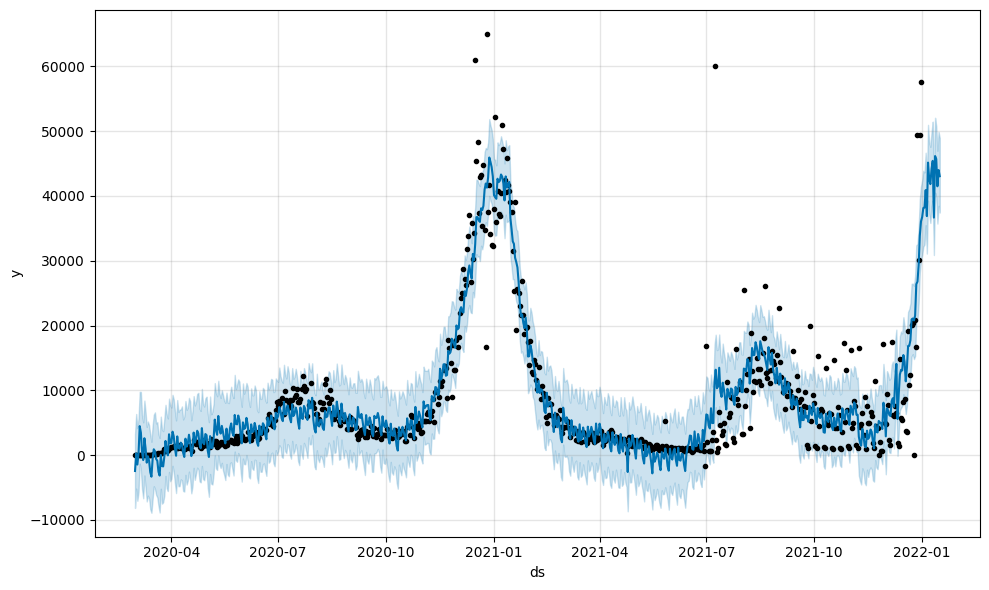

In [21]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

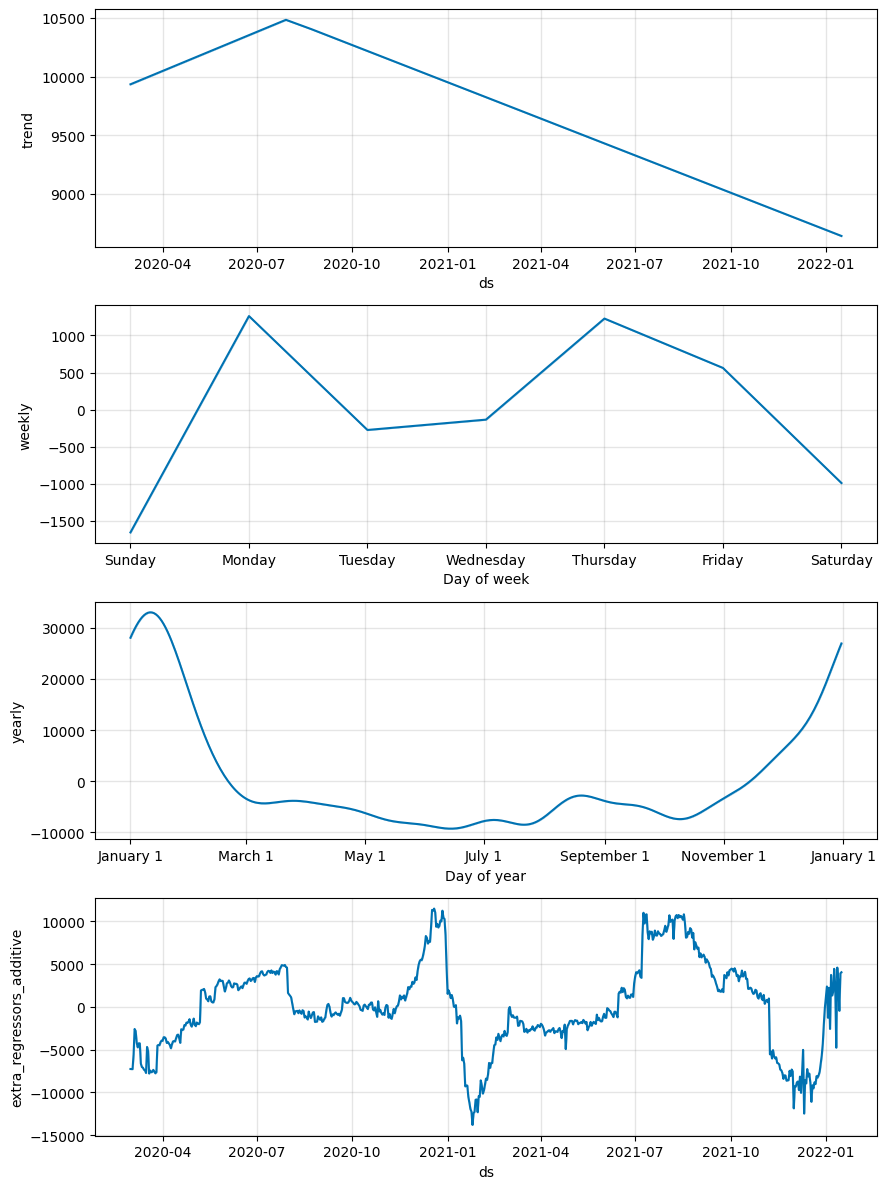

In [22]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [23]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test_final, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 51837.1928348238
The MAPE for the multivariate model is 1.0340273393921323e+19


MODEL WITH HOLIDAY AND EVENT EFFECTS

In [24]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2020-02-02,-7,1
1,superbowl,2021-02-07,-7,1


In [25]:
# Initialize the model with seasonality
model_holiday = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = events)

# Add each regressor individually
regressor_names = ['2', '7', '5', '15', '9', '6', '14', '31', '37', '39', '3', '36']
for name in regressor_names:
    model_holiday.add_regressor(name, standardize=False)

# Fit the model on the training dataset
model_holiday.fit(train_final)

#all the holidays / events
model_holiday.train_holiday_names

02:55:17 - cmdstanpy - INFO - Chain [1] start processing
02:55:17 - cmdstanpy - INFO - Chain [1] done processing


0        COVID
1    superbowl
dtype: object

In [26]:
# Create the time range for the forecast
future_multivariate_holiday = model_holiday.make_future_dataframe(periods=16)

# Append the regressor values
future_multivariate_holiday = pd.merge(future_multivariate_holiday, full_df[['ds', '2', '7', '5', '15', '9', '6', '14', '31', '37', '39', '3', '36']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate_holiday = future_multivariate_holiday.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,2,11,8,4,9,7,31,3,22
677,2022-01-07,3.068745,0.523138,0.993774,-0.262017,-0.433952,0.169978,4.749799e-16,0.764774,0.152940
678,2022-01-08,3.142950,-0.263836,-1.026436,0.288796,0.092115,0.282021,-5.579988e-16,0.595783,0.101099
679,2022-01-09,2.991846,-0.519752,0.668462,-0.264779,-0.298444,-0.582936,-1.302357e-16,0.793508,0.019309
680,2022-01-10,1.406547,-0.405175,0.596348,-0.132328,0.337676,0.427915,-1.662197e-16,-0.072682,-0.055941
681,2022-01-11,-0.099808,0.972877,-1.940356,0.194200,0.617118,1.489089,2.032235e-16,-1.398290,-0.184953
682,2022-01-12,-0.229490,0.252924,-0.614570,0.294250,-0.345708,-2.618619,-4.506808e-16,-1.108080,-0.011250
683,2022-01-13,-0.729553,1.148529,1.902424,0.131062,-0.397548,-1.257430,1.203500e-15,-1.205184,0.025699
684,2022-01-14,-1.133354,0.190269,-0.527788,0.450021,-0.458005,1.133101,-2.733292e-16,-1.642054,0.131024
685,2022-01-15,-0.549081,-0.031584,-0.226746,0.621068,0.217306,-1.062289,1.029828e-16,-1.255025,0.016324
686,2022-01-16,-0.830629,-0.120559,1.083215,0.114081,0.300182,-0.941598,-6.405931e-16,-1.134593,-0.271961


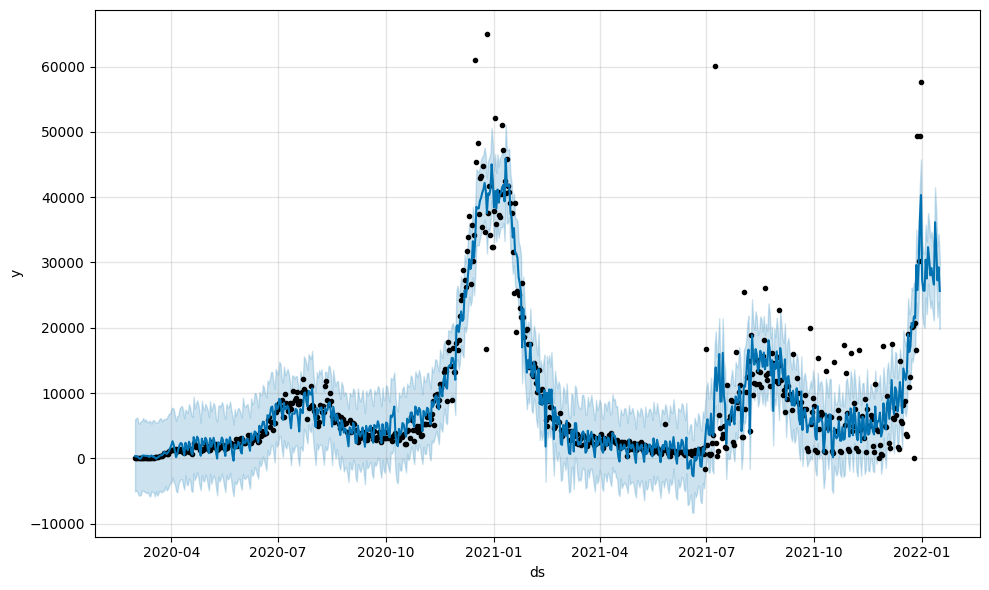

In [27]:
# Make prediction
forecast_holiday = model_holiday.predict(future_multivariate_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday);

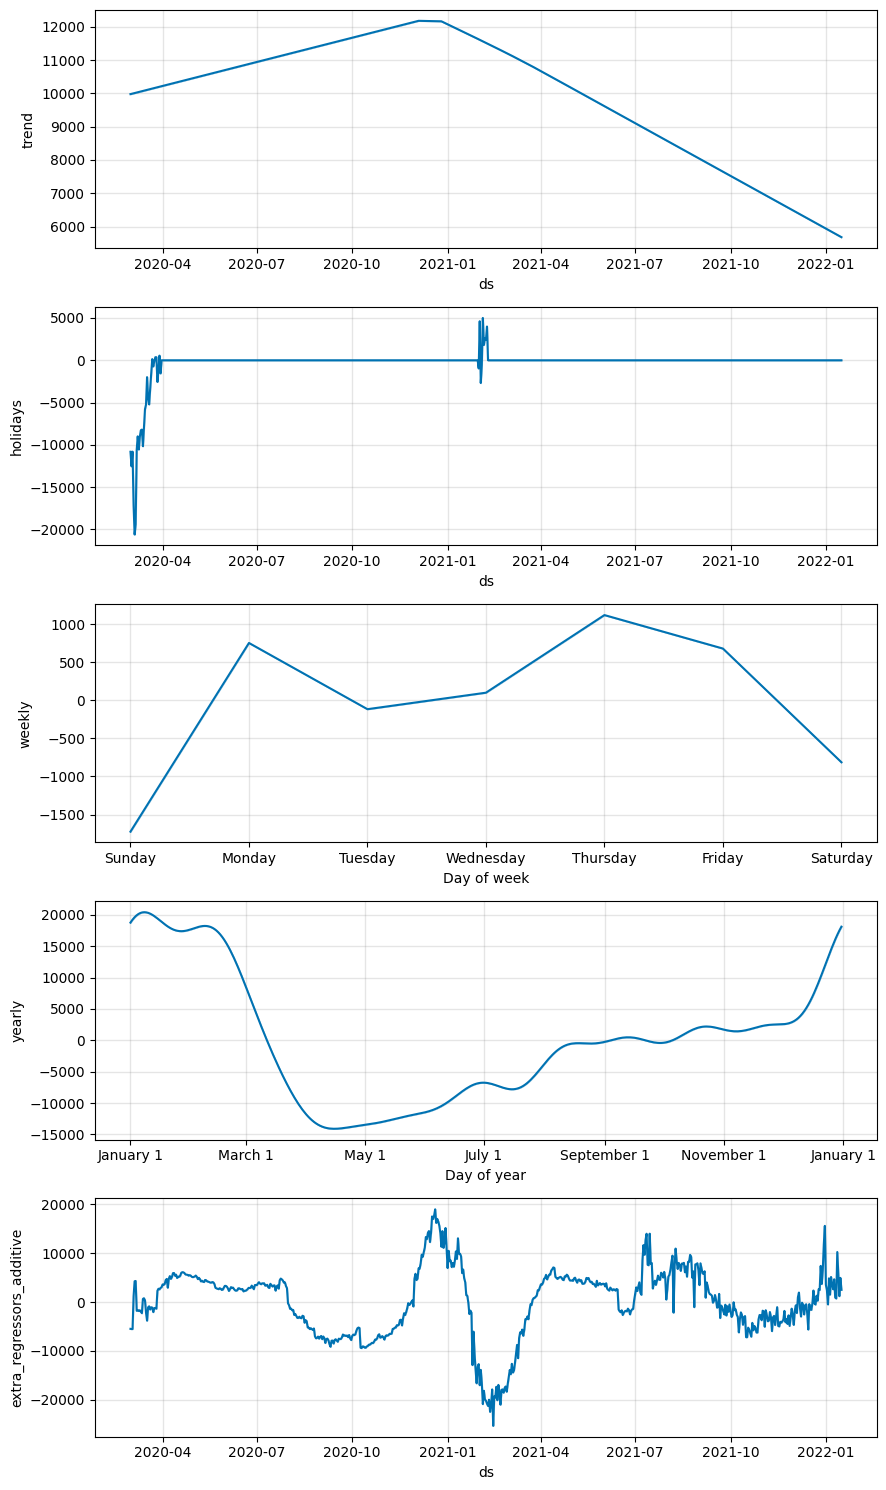

In [28]:
# Visualize the forecast components
model_holiday.plot_components(forecast_holiday);

In [29]:
# Merge actual and predicted values
performance_holiday = pd.merge(test_final, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 62303.96990939455
The MAPE for the holiday/event model is 7.676579460814138e+18


In [31]:
#naive forecast for mase calculation
naive_forecast = test_final['y'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(test_final['y'][1:], naive_forecast.dropna())
mase = performance_holiday_MAE / mae_naive
print('Test MASE: ', mase)

Test MASE:  2.663735894595243


In [33]:
#calculate performance metrics
mae = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
mse = mean_squared_error(performance_holiday['y'], performance_holiday['yhat'])
rmse = np.sqrt(mse)
print('Test RMSE: ', rmse)

Test RMSE:  81600.30630340637
